In [ ]:
from app.services.hantu_services.auth_service import AuthService


auth_service = AuthService()
# access token 발급
access_token = auth_service.get_access_token()

In [5]:
from app.services.hantu_services.quotations_service import QuotationsService


quotations_service = QuotationsService(access_token)

In [ ]:
# 주식현재가 시세
inquire_price_res = quotations_service.inquire_price("005930")

In [ ]:
print(
    inquire_price_res["stck_prpr"],  # 주식 현재가
    inquire_price_res["prdy_vrss"],  # 전일대비
    inquire_price_res["prdy_ctrt"],  # 전일대비율
    inquire_price_res[
        "prdy_vrss_sign"
    ],  # 전일 대비 부호 1: 상한, 2: 상승, 3: 보합, 4: 하한, 5: 하락
    inquire_price_res["stck_oprc"],  # 주식 시가
    inquire_price_res["stck_hgpr"],  # 주식 최고가
    inquire_price_res["stck_lwpr"],  # 주식 최저가
    inquire_price_res["stck_mxpr"],  # 주식 상한가
    inquire_price_res["stck_llam"],  # 주식 하한가
    inquire_price_res["stck_sdpr"],  # 주식 기준가
    inquire_price_res[
        "mrkt_warn_cls_code"
    ],  # 시장경고코드 00: 없음, 01: 투자주의, 02: 투자경고, 03: 투자위험
)

In [8]:
from app.services.hantu_services.trading_service import TradingService


trading_service = TradingService(access_token)

In [9]:
# 주식주문(현금)
order_cash_res = trading_service.order_cash("005930", "1", "40000")

In [ ]:
# 주식일별주문체결조회
inquire_daily_ccld_res = trading_service.inquire_daily_ccld()
print(inquire_daily_ccld_res)
# inquire_daily_ccld_res[0]["odno"]  # 주문번호

In [ ]:
def filter_ticker(obj):
    return True if obj["pdno"] == "005930" else False


filtered_list = list(filter(filter_ticker, inquire_daily_ccld_res))

if len(filtered_list) > 0:
    # 주식주문(정정취소)
    order_rvsenclcl_res = trading_service.order_rvsecncl(filtered_list[0]["odno"])
    print(order_rvsenclcl_res["msg_cd"], order_rvsenclcl_res["msg1"])
else:
    print("주문번호가 존재하지 않습니다.")

In [1]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

engine = create_engine("sqlite:///./app/connection/test.db", echo=False)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
session = SessionLocal()

In [2]:
import pandas as pd
from sqlalchemy import func
from app.entities.kor_ticker_entity import KorTickerEntity


max_subquery = session.query(func.max(KorTickerEntity.baseDt))
query_set = session.query(KorTickerEntity).filter(
    KorTickerEntity.baseDt == max_subquery.scalar_subquery(),
    KorTickerEntity.itemCtg == "보통주",
)
tickers_df = pd.read_sql(query_set.statement, query_set.session.bind)

In [4]:
# 시총 작은 순위로 20개 정렬
ticker_rank = tickers_df["mrktTotAmt"].rank(axis=0, ascending=True)
result_rank = tickers_df[ticker_rank < 20].sort_values(
    by=["mrktTotAmt"], ascending=True
)

In [2]:
import pandas as pd

from app.services.kor_price_service import KorPriceService


kor_price_service = KorPriceService(session)
price_df = kor_price_service.get_year_price(is_df=True, years=10)
price_df["baseDt"] = pd.to_datetime(price_df["baseDt"])  # 날짜형식으로 변환
price_df = price_df.sort_values(by=["itemCd", "baseDt"], ascending=True).reset_index(
    drop=True
)

In [3]:
import pandas_ta as ta
import pandas as pd


def get_price_df_sma(df: pd.DataFrame):

    # 각 종목별로 다양한 기간의 SMA 계산
    def calculate_sma(group, lengths):
        for length in lengths:
            group[f"SMA_{length}"] = ta.sma(group["closePrice"], length=length)
        return group.dropna(how="all", axis=1)

    df["ticker"] = df["itemCd"]
    # 원하는 SMA 기간들
    sma_lengths = [10, 20, 50, 120]
    # 그룹화하여 SMA 계산 적용
    return (
        df.groupby("itemCd")
        .apply(lambda x: calculate_sma(x, sma_lengths), include_groups=False)
        .reset_index(drop=True)
    )


price_df_sma = get_price_df_sma(price_df)
# price_merge = price_df_sma.merge(price_df["itemCd"], left_index=True, right_index=True)

In [ ]:
select_ticker = "311390"
one_price = price_df_sma[price_df_sma["ticker"] == select_ticker]
one_price = one_price.iloc[119:]

ax1 = one_price.plot(figsize=(10, 6), x="baseDt", y="closePrice", title=select_ticker)
ax2 = one_price.plot(figsize=(10, 6), x="baseDt", y="SMA_10", ax=ax1)
ax3 = one_price.plot(figsize=(10, 6), x="baseDt", y="SMA_20", ax=ax1)
ax4 = one_price.plot(figsize=(10, 6), x="baseDt", y="SMA_50", ax=ax1)
ax5 = one_price.plot(figsize=(10, 6), x="baseDt", y="SMA_120", ax=ax1)

ax1.set_ylabel("Price")
ax1.set_xlabel("Month")

In [30]:
from pandas import DataFrame


def get_price_merge_remove(df: DataFrame):
    df["ticker_1"] = df["ticker"]

    def removeNa(group):
        return group.iloc[119:]

    return (
        df.groupby(by="ticker")
        .apply(removeNa, include_groups=False)
        .reset_index(drop=True)
    )


price_merge_remove = get_price_merge_remove(price_df_sma)

In [32]:
from pandas import DataFrame


def get_filtered_last_data(df: DataFrame):

    df["ticker"] = df["ticker_1"]

    def filter_last(group):
        return group.iloc[-1:]

    return (
        df.groupby(by="ticker_1")
        .apply(filter_last, include_groups=False)
        .reset_index(drop=True)
    )


filtered_last_data = get_filtered_last_data(price_merge_remove)

In [6]:
filtered_last_data = filtered_last_data.query(
    "closePrice > SMA_10 and SMA_10 > SMA_20 and SMA_20 > SMA_50 and SMA_50 > SMA_120"
)

In [17]:
import pandas as pd
import bt
import numpy as np


def custom_backtest(df: DataFrame, ticker: str, name: str):
    # 선택한 티커에 해당하는 데이터 필터링
    select_ticker = ticker
    one_price = df[df["ticker"] == select_ticker]
    # one_price = one_price.iloc[119:].reset_index(drop=True)

    # 필요한 칼럼 선택 및 인덱스 설정
    one_price = one_price[
        ["baseDt", "closePrice", "SMA_10", "SMA_20", "SMA_50", "SMA_120"]
    ]
    one_price.set_index("baseDt", inplace=True)
    one_price.index = pd.to_datetime(one_price.index)

    # 조건 정의 및 1/0 값 할당
    one_price["condition"] = np.where(
        (one_price["closePrice"] > one_price["SMA_10"])
        & (one_price["SMA_10"] > one_price["SMA_20"])
        & (one_price["SMA_20"] > one_price["SMA_50"])
        & (one_price["SMA_50"] > one_price["SMA_120"]),
        one_price["closePrice"],
        one_price["SMA_10"],
    )

    # NaN 값 제거
    one_price.dropna(inplace=True)

    # 조건 충족 여부 확인
    if one_price["condition"].sum() == 0:
        raise ValueError("조건을 충족하는 데이터가 없습니다.")

    def con(x):
        return x

    sma = one_price[["condition"]].apply(lambda x: con(x))
    # print(sma, one_price[["condition"]])
    # 전략 정의
    strategy = bt.Strategy(
        name,
        [
            bt.algos.SelectWhere(sma >= one_price[["condition"]]),
            bt.algos.WeighEqually(),
            bt.algos.Rebalance(),
        ],
    )
    # 초기 자산 설정
    return bt.Backtest(strategy, one_price, initial_capital=10_000_000)

In [ ]:
stg1 = custom_backtest("001380", "001380")
stg2 = custom_backtest("001800", "001800")


result = bt.run(stg1, stg2)
# # 결과 시각화
result.plot()

In [ ]:
# result.plot()
# 성과지표
result.stats

In [24]:
import numpy as np


def year_amt(group):
    year = group.iloc[-245:].reset_index(drop=True)
    # print(year)
    first_day = year.iloc[0:1].reset_index(drop=True)
    last_day = year.iloc[-1:].reset_index(drop=True)
    # print((last_day["closePrice"] - first_day["closePrice"]).iloc[0])
    group = group.assign(
        ok=np.where(
            (last_day["closePrice"] - first_day["closePrice"]).iloc[0] > 0, "Y", "N"
        )
    )

    return group


test = price_df_sma.groupby(by="ticker_1").apply(
    lambda x: year_amt(x), include_groups=False
)

In [25]:
test = test[test["ok"] == "Y"]

In [31]:
test = get_price_merge_remove(test)

In [33]:
test_filter = get_filtered_last_data(test)
test_filter_last_data = test_filter.query(
    "closePrice > SMA_10 and SMA_10 > SMA_20 and SMA_20 > SMA_50 and SMA_50 > SMA_120"
)

100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


<Axes: title={'center': 'Equity Progression'}>

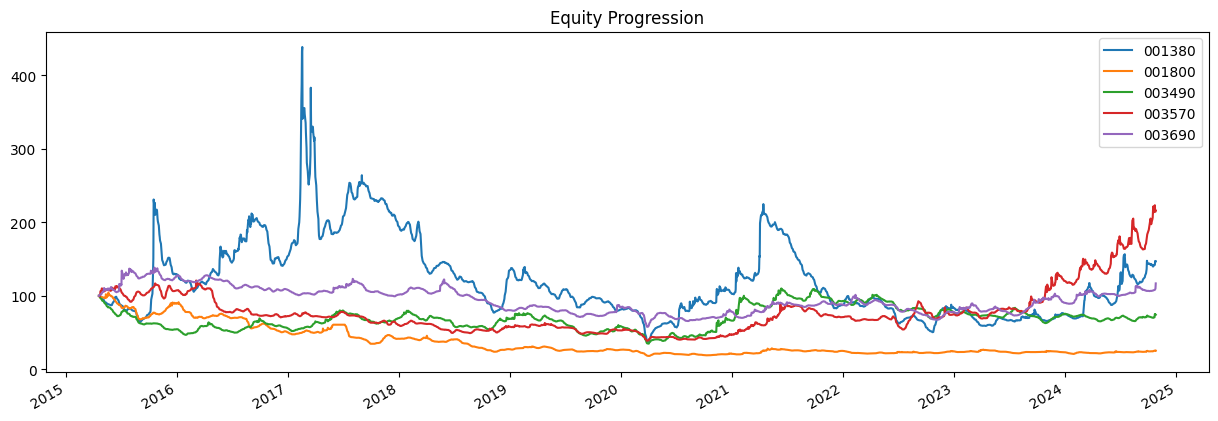

In [34]:
stg1 = custom_backtest(test, "001380", "001380")
stg2 = custom_backtest(test, "001800", "001800")
stg3 = custom_backtest(test, "003490", "003490")
stg4 = custom_backtest(test, "003570", "003570")
stg5 = custom_backtest(test, "003690", "003690")


result = bt.run(stg1, stg2, stg3, stg4, stg5)
# # 결과 시각화
result.plot()

In [35]:
result.stats

,001380,001800,003490,003570,003690
start,2015-04-19 00:00:00,2015-04-19 00:00:00,2015-04-19 00:00:00,2015-04-19 00:00:00,2015-04-19 00:00:00
end,2024-10-25 00:00:00,2024-10-25 00:00:00,2024-10-25 00:00:00,2024-10-25 00:00:00,2024-10-25 00:00:00
rf,0.0,0.0,0.0,0.0,0.0
total_return,0.469853,-0.745175,-0.256713,1.160083,0.169322
cagr,0.04129,-0.133782,-0.030684,0.084265,0.016568
max_drawdown,-0.91445,-0.826787,-0.651855,-0.677963,-0.582374
calmar,0.045153,-0.161809,-0.047072,0.124291,0.028449
mtd,0.025554,0.033962,0.033259,0.153929,0.095108
three_month,0.06179,0.085433,0.074226,0.286173,0.135242
six_month,0.492655,0.174701,0.138637,0.58224,0.168847
